In [8]:
import os
from forg.feature import *

In [9]:
repo_dir = "../data/repos/react"

raw_files: list[RawFile] = []

for dir, _, files in os.walk(repo_dir):
    for file in files:
        path = os.path.join(dir, file)
        raw_files.append(RawFile(path=path, repo_dir=repo_dir))

In [10]:
feature = Feature(device="mps")

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Embedding batches: 0it [00:00, ?it/s]
Embedding batches: 0it [00:00, ?it/s]
Embedding batches: 0it [00:00, ?it/s]
100%|██████████| 5000/5000 [01:33<00:00, 53.56it/s]


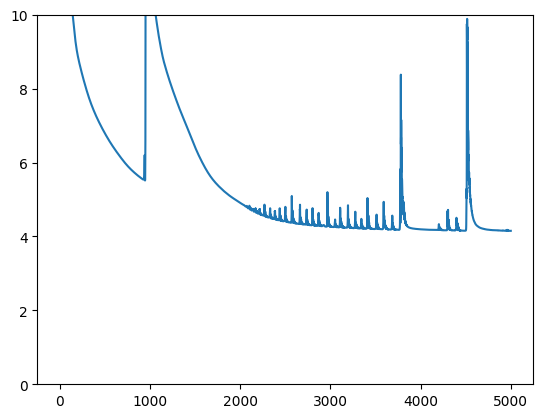

In [27]:
from tqdm import tqdm
import torch
import matplotlib.pyplot as plt
from forg.embedding import *
from forg.metric import *

files: list[FileFeatures] = feature(raw_files[:1000])

target_dist_matrix = tree_distance_matrix(files)  # shape: (N, N)

embedding = Embedding(feature=feature, D=2, width=512, depth=2)


def loss():
    embeddings = embedding(files)  # shape: (N, D)
    dist_matrix = torch.cdist(embeddings, embeddings)  # shape: (N, N)
    squared_error = (dist_matrix - target_dist_matrix) ** 2
    return squared_error.mean()


# training loop

epochs = 5_000
lr = 0.01

optimizer = torch.optim.Adam(embedding.parameters(), lr=lr)

losses = []

for epoch in tqdm(range(epochs)):
    l = loss()
    l.backward()
    optimizer.step()
    optimizer.zero_grad()
    losses.append(l.item())

plt.plot(losses)
plt.ylim(0, 10)
plt.show()

embeddings = embedding(files).cpu().detach()

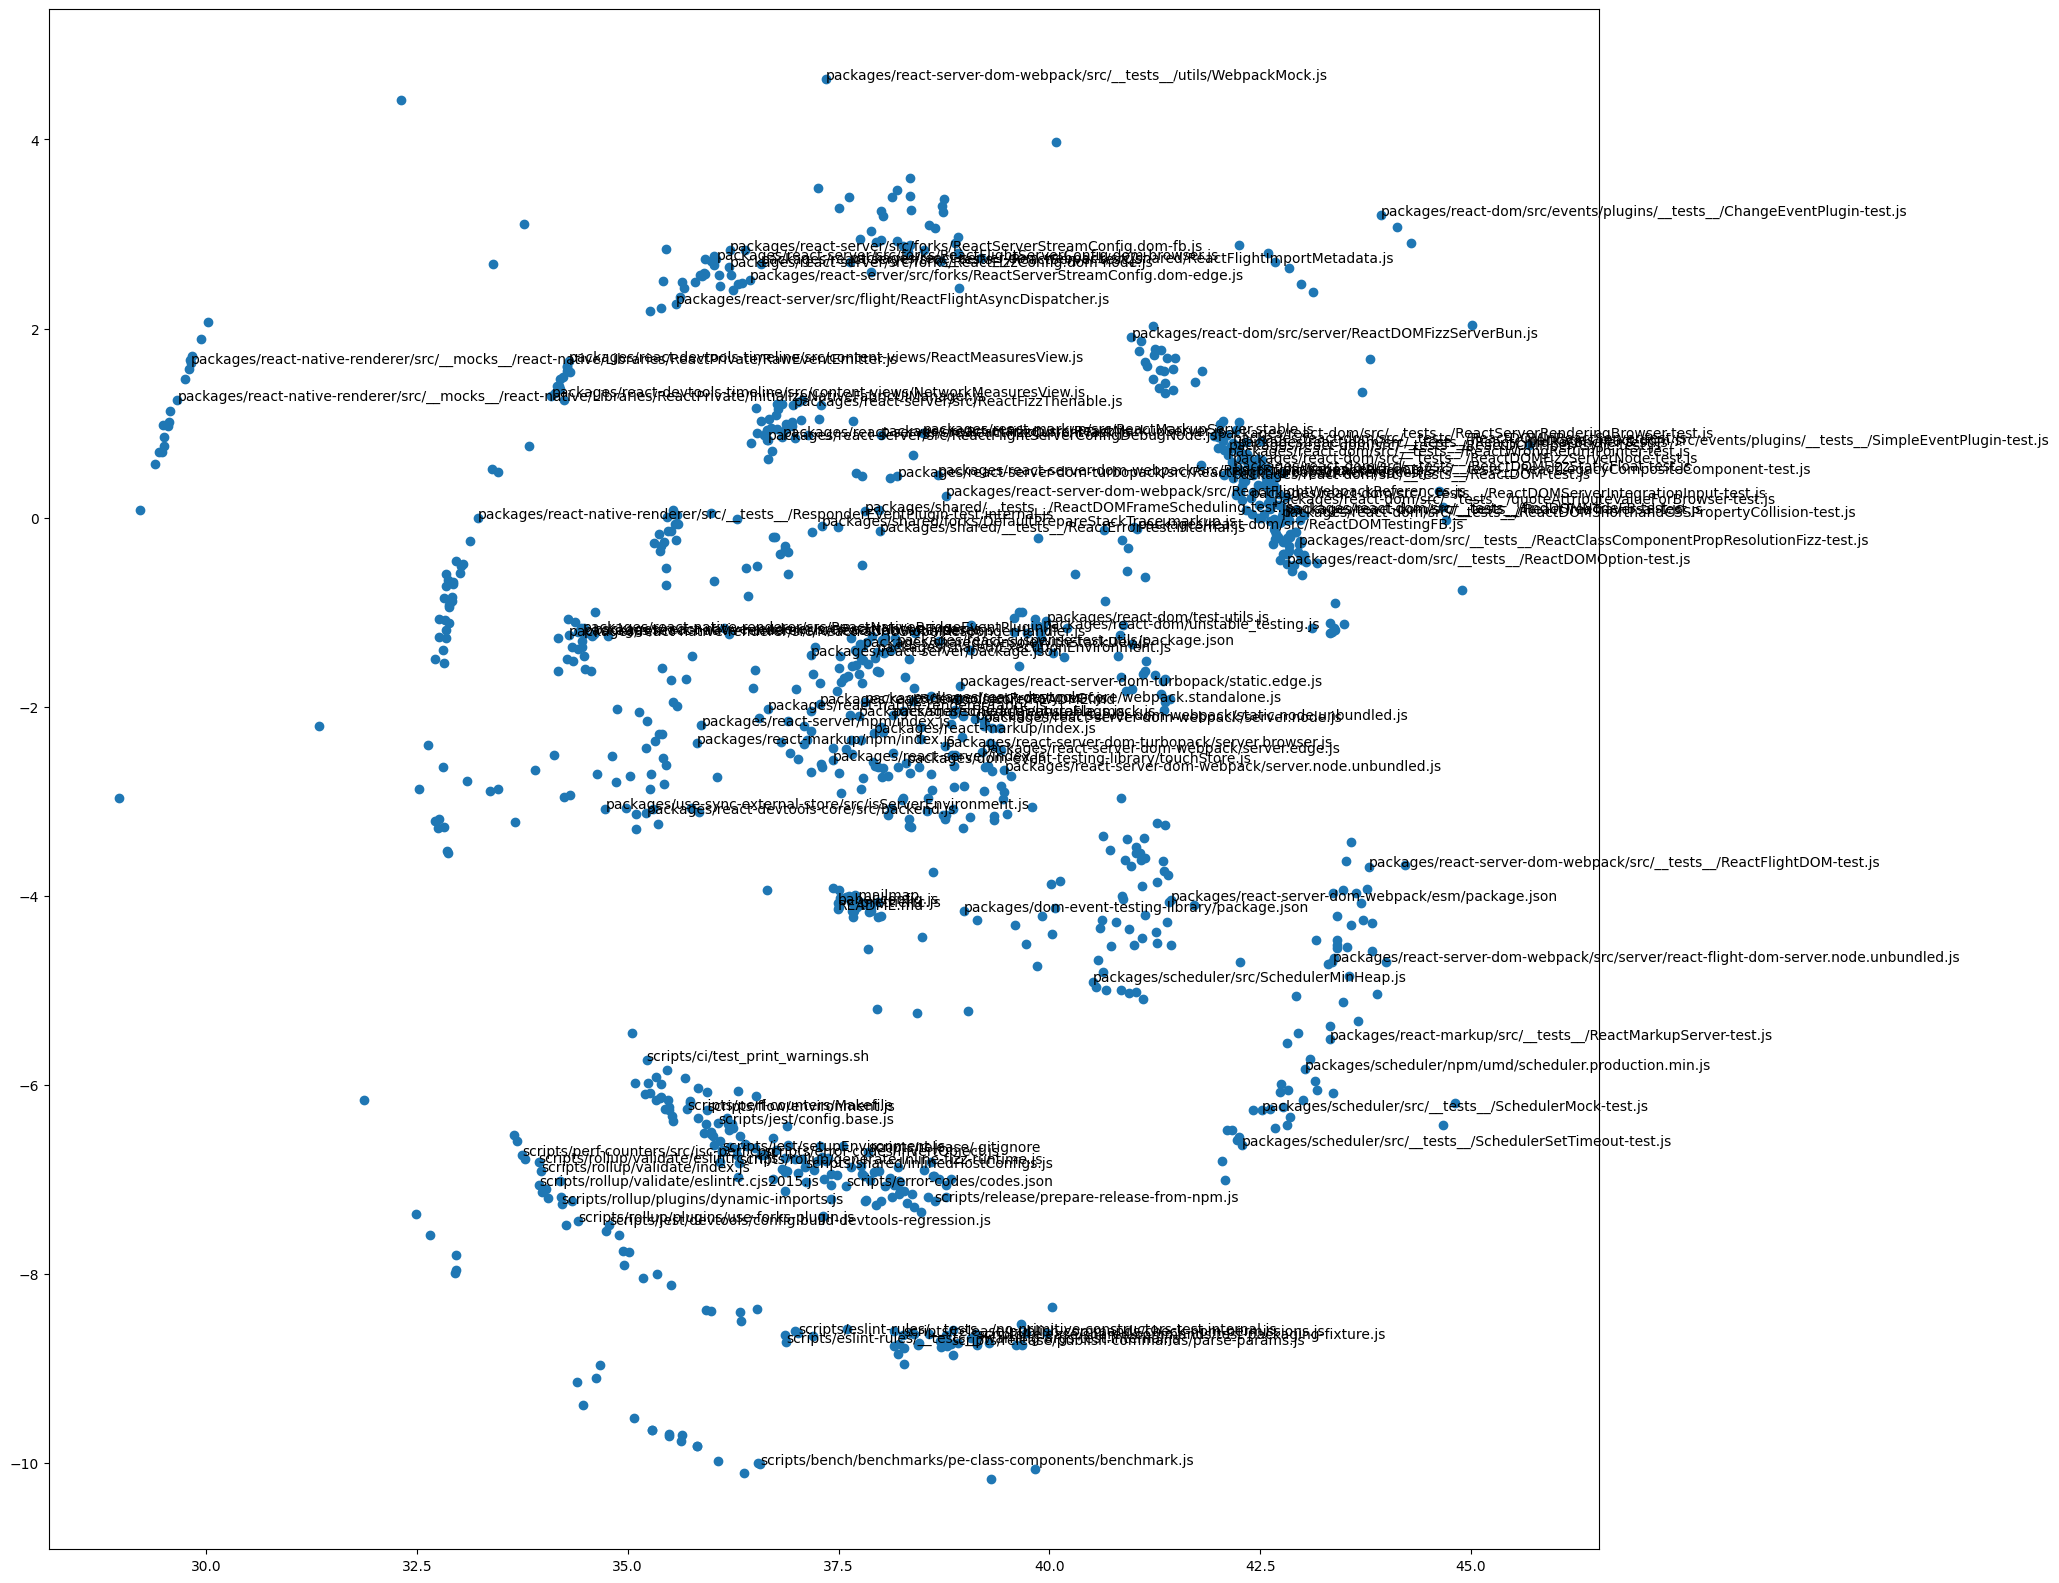

In [35]:
import random

plt.figure(figsize=(20, 20))  # Set the figure size to be super huge
plt.scatter(embeddings[:, 0], embeddings[:, 1])

for i, file in enumerate(files):
    if random.random() < 0.1:
        plt.annotate(
            file.relative_path.replace("react/", ""),
            (embeddings[i, 0], embeddings[i, 1]),
        )

plt.show()